
### _Creating the Python Environment:_

_Ensure that Anaconda is installed on your system, then create a new conda virtual environment named __SeisTF2__, and activate it:_

    conda create -n SeisTF2

    conda activate SeisTF2
    
    

_Next, install the basic anaconda packages, geoscience packages, xgboost and gpu acceleration packages:_

    conda install -c anaconda anaconda
    
    conda install -c conda-forge obspy cartopy geographiclib
    
    conda install -c conda-forge xgboost eli5
    
    conda install cudnn cupti cudatoolkit=10.0
    
    

_Finally, use pip to install tensorflow 2.0 with gpu support:_

    pip install tensorflow-gpu
    
    
### _Running the Notebook:_

_Save the attached SeisQC.ipynb file to your local computer, and open a terminal in the folder where it resides, then type the following:_

    conda activate SeisTF2
    
    jupyter notebook
    
_Your web browser should now open to show the contents of the folder from which you activated the notebook. Simply click on the __SeisQC.ipynb__ file and the notebook should open._
    

In [1]:
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import datetime
from obspy import read
import obspy
import os
import matplotlib.pylab as plt
%matplotlib inline
from scipy.signal import lfilter, butter, decimate, hann
%load_ext autoreload
%autoreload 2

from UTILS import *
from wfdisc_utils import WFDISC
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv1D, SpatialDropout1D
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.layers import Convolution1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
import tensorflow.keras.layers
import tensorflow.keras as keras


# Define Folders for saving Models/Logs
model_folder = 'models'
log_folder = 'logs'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
if not os.path.exists(log_folder):
    os.makedirs(log_folder)
    
    
import obspy
import os
import re
import math
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats

import matplotlib
import urllib.request
import seaborn as sns
# import cartopy.crs as ccrs
# import cartopy.io.img_tiles as cimgt
# import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
# import xgboost as xgb
# from eli5 import show_weights
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import joblib

import datetime
import obspy
from obspy.clients.fdsn import Client
import obspy.core.stream as Stream

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, add
from tensorflow.keras.utils import to_categorical

from time import localtime, strftime
import warnings

warnings.filterwarnings("ignore",category=FutureWarning)
pd.set_option('display.max_columns', 500)

model_folder='models/'
log_folder='logs/'
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
if not os.path.exists(log_folder):
    os.mkdir(log_folder)

# DeepPick:

This Notebook details the development of a simple Picking algorithm for three-component Seismograms:


We will proceed in three parts:

1) Data Wrangling

2) Model Architecture

3) Training and Testing


# STEP 1: Data Wrangling

### Load Bulletin:

To train and test the algorithm, we utilize the Uncontstrained Utah Event Bulletin (UUEB) produced by Sandia National Lab. The UUEB relies on data collected by the  University of Utah Seismograph Stations (UUSS). Catalog events and associated signal detections are in tables that follow the Center for Seismic Studies 3.0 (CSS3.0) database schema. Station metadata information is in tables (sensor, instrument, affiliation, network, site, and sitechan) that follow the National Nuclear Security Administration Knowledge Base Core Table (NNSA KB Core). We first Download the Oracle database flat file exports (tab delimited) for the UUEB here:

https://www.sandia.gov/uueb/

In [2]:
def read_cat(filename):
    cat = pd.read_csv(filename, index_col=0)
    cat['TIME'] = pd.to_datetime(cat['TIME'])
    cat.fillna('', inplace=True)
    cat = cat.sort_values(by=['TIME'])
    cat.reset_index(drop=True, inplace=True)
    return cat

In [4]:
cat = read_cat('data/IDCLEB_arrivals_arrays_13_15.csv')

In [5]:
print(list(cat.IPHASE.value_counts().index))

['P', 'LR', 'tx', 'Pn', 'N', 'Sx', 'PcP', 'Lg', 'Sn', 'S', 'PKP', 'Pg', 'ScP', 'pP', 'PP', 'Px', 'PKi', 'PKK', 'Rg', 'SKP', 'Pdi', 'ScS', 'P3K', 'pPK', 'PKh', 'sP', 'P4K', 'SKK', 'Sdi', 'SKi']


In [6]:
# Define Training Catalog
stations = ['ASAR', 'ILAR', 'MKAR', 'NVAR', 'PDAR', 'TXAR']
start_time = '2013-01-01'
end_time = '2014-01-01'
phases = ['P', 'LR']
phases = ['P', 'Pn', 'Pc', 'PcP', 'PK', 'Pg', 'PKP', 'pP', 'PP', 'Px']

# Build Training Catalog
cat =  cat.loc[(cat.STA.isin(stations)) &                    
                (cat.TIME > start_time) & 
                (cat.TIME < end_time)  &
                (cat.IPHASE.isin(phases))
              ].reset_index(drop=True)

In [7]:
phase_type_dict = {}
phase_type_map = {}

# define the new phase types in a dictionary, and assign all IPHASEs to a type:
# phase_type_dict['P'] = ['Pn', 'Pg', 'P', 'PKP', 'pP', 'I', 'sP', 'PKKPbc', 'PKP2', 'PP', 
#                         'PcP', 'SKPbc', 'PKiKP', 'pPKP', 'PKPbc', 'SKP', 'ScP', 'SKKPbc']
# phase_type_dict['S'] = ['Lg', 'Sn', 'S', 'ScS', 'Rg', 'I', 'LR']

# phase_type_dict = {}
phase_type_dict['P'] = ['Pn', 'Pg', 'P', 'PKP', 'pP', 'I', 'sP', 'PKKPbc', 'PKP2', 'PP', 
                        'PcP', 'SKPbc', 'PKiKP', 'pPKP', 'PKPbc', 'SKP', 'ScP', 'SKKPbc',
                        'Lg', 'Sn', 'S', 'ScS', 'Rg', 'I', 'LR']

# phase_type_dict = {}
# phase_type_dict['Pg'] = ['Pg']
phase_type_dict['L'] = ['LR']

# create the mapping dictionary:
for typ in phase_type_dict:
    phase_type_map.update({k:v for (k,v) in [(p, typ) for p in phase_type_dict[typ]]})
    
# create the new 'PHASE_TYPE' column and fill it with the assigned types:
cat['PHASE_TYPE'] = cat.IPHASE.map(phase_type_map)

# Check the class imbalance of the newly defined types:
cat.PHASE_TYPE.value_counts()

P    172262
Name: PHASE_TYPE, dtype: int64

We now save the catalog and display its contents.

In [8]:
cat.to_csv('cat.csv', index=False)
display(cat)

,TIME,ARID,STA,ST_LAT,ST_LON,EV_TIME,EV_LAT,EV_LON,EV_MAG,EVID,IPHASE,SNR,AZI_PRED,AZI_CERT,SLW_PRED,SLW_CERT,PHASE_TYPE
0,2013-01-01 00:00:22.250000,83040939,ASAR,-23.6651,133.9050,2012-12-31 23:56:35.113670,-7.5127,129.4330,-999.00,9351484,P,33.17,341.75,2.06,9.34,0.34,P
1,2013-01-01 00:00:22.250000,83040939,ASAR,-23.6664,133.9040,2012-12-31 23:56:35.113670,-7.5127,129.4330,-999.00,9351484,P,33.17,341.75,2.06,9.34,0.34,P
2,2013-01-01 00:03:28.325000,83294812,ASAR,-23.6651,133.9050,2012-12-31 23:56:35.113670,-7.5127,129.4330,-999.00,9351484,P,3.47,345.54,2.39,24.12,1.01,P
3,2013-01-01 00:03:28.325000,83294812,ASAR,-23.6664,133.9040,2012-12-31 23:56:35.113670,-7.5127,129.4330,-999.00,9351484,P,3.47,345.54,2.39,24.12,1.01,P
4,2013-01-01 00:34:18.891360,83293632,MKAR,46.7937,82.2904,2013-01-01 00:26:23.441950,38.6041,141.8660,3.09,9380520,P,3.76,88.98,10.02,8.87,1.55,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172424,2013-12-31 23:52:58.375000,91845524,TXAR,29.3340,-103.6680,2013-12-31 23:33:17.169450,-44.6646,37.5642,3.89,382649,P,12.22,152.11,12.05,4.62,0.97,P
172425,2013-12-31 23:53:21.962470,91845473,ILAR,64.7714,-146.8870,2013-12-31 23:41:45.004130,18.9799,120.2600,4.75,383238,P,22.30,277.01,11.41,3.56,0.71,P
172426,2013-12-31 23:55:36.875000,91845482,NVAR,38.4296,-118.3040,2013-12-31 23:41:45.004130,18.9799,120.2600,4.75,383238,P,7.13,285.03,33.21,5.69,3.25,P
172427,2013-12-31 23:58:57.424000,92090295,MKAR,46.7937,82.2904,2013-12-31 23:50:42.264350,46.8806,152.3960,3.34,383008,P,3.36,74.00,15.04,7.34,1.92,P


In [9]:
def datetime2epoch(timestamp):
    return (timestamp - datetime.datetime(1970, 1, 1)).total_seconds()

def get_wav(sta, st_time, en_time, pdict, data_dir='data/css'):
    cmpts = pdict['cmpts']
    
    X = []
    date = st_time.strftime('%Y-%-m-%-d')
    day = f'{st_time.timetuple().tm_yday:03d}'
        
    file = os.path.join(data_dir, f'{date}/{sta}.{st_time.year}{day}.wfdisc')
    wf = WFDISC(file)

    if sta[-2:] == 'AR':
        sta = sta[:-2] + '31'
        
    for chan in ['BH' + l for l in cmpts]:
        X.append(wf.getData(sta, chan, datetime2epoch(st_time), datetime2epoch(en_time), verbose=False))
    X = np.stack(X, axis=-1)
    
    if X.shape == (int(pdict['w_len'] * pdict['r_smp']), len(pdict['cmpts'])):
        return X
    else:
        raise Exception()

def DAT_normalize(X):
    X = X - np.expand_dims(np.mean(X,1),1)
    X = X / np.expand_dims(np.expand_dims(np.abs(X).max(1).max(1), 1), 1)
    return X

def butter_bandpass(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    return b, a

def DAT_filter(X, pdict, order=3):
    lowcut = pdict['f_low']
    highcut = pdict['f_hig']
    fs = pdict['r_smp']
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, X, axis=1) 

def DAT_taper(X, taper_percentage=.05):
    npts = X.shape[1]
    taper_len = int(npts * taper_percentage)
    taper_sides = hann(2 * taper_len + 1)
    taper = np.hstack((taper_sides[:taper_len], np.ones(npts - taper_len)))
    return X * np.reshape(taper,(1,-1,1))

In [10]:
pdict = {}
pdict['f_low'] = 1
pdict['f_hig'] = 4
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'
pdict['w_len'] = 60

arrival = cat.sample().iloc[0]
sta = arrival.STA
st = arrival.TIME - pd.Timedelta(pdict['w_len']/2, 's')
en = arrival.TIME + pd.Timedelta(pdict['w_len']/2, 's')

seis = get_wav(sta, st, en, pdict)

Exception: No Valid CSS Segments were read. Check your path.

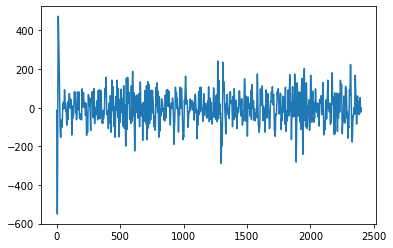

In [76]:
plt.plot(DAT_filter(np.expand_dims(seis,0), pdict)[0,:,0])

### Create Characteristic Function from catalog:

In [77]:
def get_c(c_width_in_samples, c_shape=None, c_amplitude=1, c_buffer_in_samples=0):

    if c_shape == 'gauss':
        x = stats.norm.pdf(np.linspace(-3, 3, c_width_in_samples))
        x = (x - x.min()) / (x - x.min()).max()
    else:
        x = np.ones(c_width_in_samples)

    return np.hstack([np.zeros(c_buffer_in_samples), x*c_amplitude])


def get_cFunc(indices, pdict):
    
    w_tot_samps = int(pdict['r_smp'] * pdict['w_len'])
    c_len_samps = int(pdict['r_smp'] * pdict['c_len'])
    c_buf_samps = int(pdict['r_smp'] * pdict['c_buf'])
    c_tot_samps = c_len_samps + c_buf_samps
    
    cFunc = np.zeros((w_tot_samps, 1))

    for idx in indices:
        c1 = cFunc[idx:idx + c_tot_samps, 0]
        c2 = get_c(c_len_samps, pdict['c_shp'], pdict['c_amp'], c_buf_samps)[:len(c1)]
        cFunc[idx:idx + c_tot_samps, 0] = np.maximum(c1, c2)
            
    return cFunc

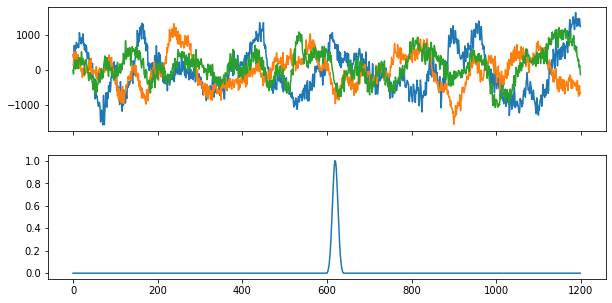

In [78]:
depth = len(cat.PHASE_TYPE.unique())+1

arrival = cat.sample().iloc[0]
win_len = 30
sta = arrival.STA
st = arrival.TIME - pd.Timedelta(win_len/2, 's')
en = arrival.TIME + pd.Timedelta(win_len/2, 's')

my_cat = cat.loc[(cat.STA == sta) & (cat.TIME >= st) & (cat.TIME <= en)]
arr_idx = [int(np.floor((t - st).total_seconds() * pdict['r_smp'])) for t in my_cat.TIME]

pdict={}
pdict['w_len'] = 30
pdict['c_len'] = 1
pdict['c_buf'] = 0
pdict['c_shp'] = 'gauss'
pdict['c_amp'] = 1
pdict['f_low'] = 1
pdict['f_hig'] = 4
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'
pdict['task'] = 'c'
pdict['nb_cl'] = len(cat.PHASE_TYPE.unique())

seis = get_wav(sta, st, en, pdict)
cFunc = get_cFunc(arr_idx, pdict)

fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
_ = ax[0].plot(seis)
_ = ax[1].plot(cFunc)


# STEP 2: Model Architecture

### Deep Temporal Convolutional Neural Network:


In [79]:
def RecFldLen(pdict):
    r = 0
    for d in pdict['d']:
        r = r + d * (pdict['k']-1)
    return f'{r/pdict["r_smp"]} seconds'

def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):
    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = add([prev_x, x])
    return res_x, x


def encoder_network(pdict, padding='causal', drop=0.05):
    
    nb_chan    = len([char for char in pdict['cmpts']])
    nb_filters = pdict['f']
    filter_len = pdict['k']
    dilations  = pdict['d']
    nb_stacks  = pdict['s']
    
    o_act = 'sigmoid'
    if pdict['c_shp'] == 'gauss':
        o_act = 'linear'
    
    input_layer = Input(shape=(None, nb_chan))

    x = input_layer

    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(x,
                                         dilation_rate=d,
                                         nb_filters=nb_filters,
                                         kernel_size=filter_len,
                                         padding=padding,
                                         dropout_rate=drop)
            skip_connections.append(skip_out)

    x = add(skip_connections)

    output_layer = Dense(1, activation=o_act, name='output')(x)

    return Model(input_layer, output_layer, name='encoder_model')

In [80]:

def load_custom_model(pdict, model_folder='models'):

    if 'iniW' in pdict.keys():
        model_name = [n for n in os.listdir(model_folder) if f'|time:{pdict["iniW"]}' in n][0]
        model_file = os.path.join(model_folder, model_name)

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        model = load_model(model_file)
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)

        print('building new model:\n', model_file)
        model = encoder_network(pdict)

    loss = 'binary_crossentropy'
    if pdict['c_shp'] == 'gauss':
        loss = 'mse'
                      
    o = Adam(lr=pdict['lr'], clipnorm=1.)
                      
    model.compile(loss=loss, optimizer=o)
    print(f'Receptive Field Length: {RecFldLen(pdict)}')

    return model, model_name



def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    model_filename = os.path.join(model_folder, model_name + '.h5')

    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]


def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)


def name2param(name):
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key][:-1]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

### Generator Function:

In [151]:

def gen(cat, pdict):
    bs = pdict['bs']
    w_len_samps = int(pdict['r_smp'] * pdict['w_len'])
    cat = cat.copy().loc[cat.SNR > pdict['w_snr']]
    
    while 1:
        X = []
        Y = []

        while len(X) < bs:
            
            try:

                rec = cat.sample().iloc[0]
                sta = rec.STA
                st = rec.TIME - pd.Timedelta(pdict['w_len'] / 2, 's')
                en = rec.TIME + pd.Timedelta(pdict['w_len'] / 2, 's')
                trace = get_wav(sta, st, en, pdict)
                
                my_cat = cat.loc[(cat.STA == sta) & (cat.TIME >= st) & (cat.TIME <= en)]
                arr_idx = [int(np.floor((t - st).total_seconds() * pdict['r_smp'])) for t in my_cat.TIME]
                cFunc = get_cFunc(arr_idx, pdict)

                
                X.append(trace)
                Y.append(cFunc)
            except:
                pass

        X = np.stack(X)
        Y = np.stack(Y)

        
        if not pdict['c_shp'] == 'gauss':
            Y = Y > 0

        X = DAT_normalize(DAT_taper(DAT_filter(X, pdict)))
        yield X, Y

In [152]:
def gen(cat, pdict):
    bs = pdict['bs']
    w_len_samps = int(pdict['r_smp'] * pdict['w_len'])
    cat = cat.copy().loc[cat.SNR > pdict['w_snr']]
    nb_chans = len(pdict['cmpts'])
    
    while 1:
        X = np.zeros((bs, w_len_samps, nb_chans))
        Y = np.zeros((bs, w_len_samps, 1))
        
        batch_counter = 0

        while batch_counter < bs:
            
            try:

                rec = cat.sample().iloc[0]
                sta = rec.STA
                st = rec.TIME - pd.Timedelta(pdict['w_len'] / 2, 's')
                en = rec.TIME + pd.Timedelta(pdict['w_len'] / 2, 's')
                trace = get_wav(sta, st, en, pdict)
                
                my_cat = cat.loc[(cat.STA == sta) & (cat.TIME >= st) & (cat.TIME <= en)]
                arr_idx = [int(np.floor((t - st).total_seconds() * pdict['r_smp'])) for t in my_cat.TIME]
                cFunc = get_cFunc(arr_idx, pdict)

                X[batch_counter], Y[batch_counter] = trace, cFunc
                batch_counter += 1
            except:
                pass
        
        if not pdict['c_shp'] == 'gauss':
            Y = Y > 0

        X = DAT_normalize(DAT_taper(DAT_filter(X, pdict)))
        yield X, Y
        

In [153]:
pdict={}
pdict['bs']    = 20
pdict['w_len'] = 300
pdict['c_len'] = 2
pdict['c_buf'] = 0
pdict['w_snr'] = 40
pdict['c_shp'] = 'gauss'
pdict['c_amp'] = 1
pdict['f_low'] = 1
pdict['f_hig'] = 4
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'

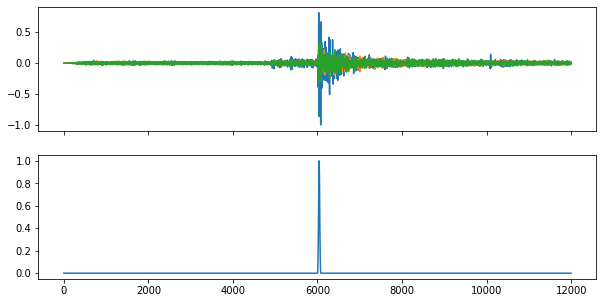

In [154]:
my_gen = gen(cat, pdict)
XX, YY = next(my_gen)

idx = np.random.randint(pdict['bs'])
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
_ = ax[0].plot(XX[idx])
_ = ax[1].plot(YY[idx])

# STEP 3: Train and Test

### Partition Data:

We now split the dataset into three partitions: Train, Validation and Test

In [155]:
cat_trn = cat.loc[cat.TIME <= '2013-11-01']
cat_val = cat.loc[(cat.TIME > '2013-11-01') & (cat.TIME <= '2013-12-01')]
cat_tst = cat.loc[cat.TIME > '2013-12-01']

In [156]:
for name, my_cat in [('Training Set', cat_trn), ('Validation Set', cat_val), ('Test Set', cat_tst)]:
 
    print(name,'\n----------------------')
    print('START TIME:', my_cat.TIME.min())
    print('  END TIME:', my_cat.TIME.max())
    print('# STATIONS:', len(my_cat.STA.unique()))
    for phs in cat.PHASE_TYPE.unique():
        print(f'# ARIV ({phs}):', len(my_cat.loc[my_cat.PHASE_TYPE == phs]))
    print('\n')

Training Set 
----------------------
START TIME: 2013-01-01 00:00:22.250000
  END TIME: 2013-10-31 23:59:49.591500
# STATIONS: 6
# ARIV (P): 145647
# ARIV (nan): 0


Validation Set 
----------------------
START TIME: 2013-11-01 00:01:07.200000
  END TIME: 2013-11-30 23:54:11.150000
# STATIONS: 6
# ARIV (P): 13117
# ARIV (nan): 0


Test Set 
----------------------
START TIME: 2013-12-01 00:08:10.875000
  END TIME: 2013-12-21 23:55:57.850000
# STATIONS: 6
# ARIV (P): 8865
# ARIV (nan): 0




### Map Data:

Examine the geographical distribution of stations and events across the three datasets:

In [157]:
def plot_cat_map(df, img_name='', ax=None):
    ax = ax or plt.gca(projection=ccrs.PlateCarree())
    ax.cla()

    ax.coastlines('110m')
    df_events = df.drop_duplicates(subset=['EVID'], keep='first', inplace=False)
    
    # Plot events.
    lons = df_events.EV_LON.values
    lats = df_events.EV_LAT.values
    ax.plot(lons, lats, '.', markersize=3, alpha=1, color='#ff6666', label='events', markerfacecolor='none')

    # Plot stations.
    df_sta = df.sort_values('ST_TIME').drop_duplicates(subset=['STA'], keep='first', inplace=False)

    lons = df_sta.ST_LON.values
    lats = df_sta.ST_LAT.values
    ax.plot(lons, lats, 'x', markersize=7, alpha=1, color='black', label='stations', markerfacecolor='none')
 
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, fontsize=10, loc='lower right')

    ax.set_title(img_name)

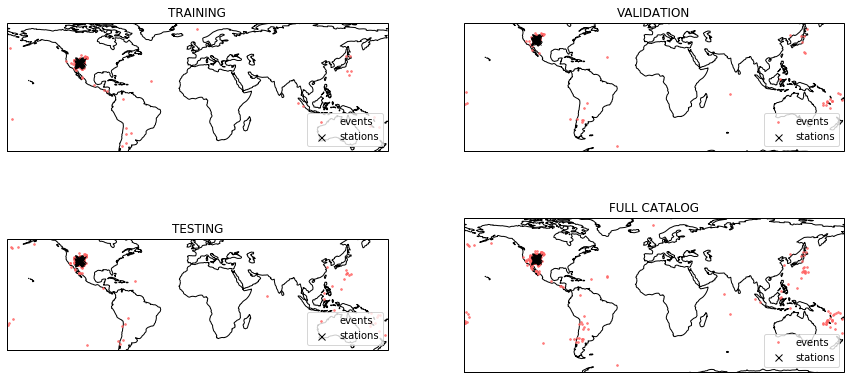

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(15,7), subplot_kw={'projection': ccrs.PlateCarree()})
plot_cat_map(cat_trn, img_name='TRAINING', ax=ax[0,0])
plot_cat_map(cat_val, img_name='VALIDATION', ax=ax[0,1])
plot_cat_map(cat_tst, img_name='TESTING', ax=ax[1,0])
plot_cat_map(cat, img_name='FULL CATALOG', ax=ax[1,1])

Next we train the model:

In [ ]:
pdict = {}
pdict['f']     = 45
pdict['k']     = 15
pdict['d']     = [1, 2, 4, 8, 16]
pdict['s']     = 2

pdict['bs']    = 20
pdict['w_len'] = 3*60
pdict['c_len'] = 2
pdict['w_snr'] = 10
pdict['c_buf'] = 10
pdict['c_shp'] = 'gauss'
pdict['c_amp'] = 1
pdict['f_low'] = 1
pdict['f_hig'] = 10
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'

pdict['lr']    = 0.0001
pdict['pat']   = 3


t_step = 100
v_step = 10

pdict['pat'] = 0
pdict['lr']    = 0.0001

my_weights = None
# my_weights = model.get_weights()

for snr in [10, 8, 5, 3, 2, 1, 0]:
    
    # instatiate a new model with progressive snr, patience and learning rates
    my_time = strftime("%y-%m-%d-%H-%M-%S", localtime())
    pdict['time']  = my_time
    
    pdict['w_snr'] = snr
    pdict['w_len'] = 3*60
    pdict['pat']   += 3
    pdict['lr'] /= 3

    pdict['w_len'] = 5*60
    gen_val = gen(cat_val, pdict)
    
    pdict['w_len'] = 30
    gen_trn = gen(cat_trn, pdict)

    model, model_name = load_custom_model(pdict)
    model.summary()
    
    # Load weights from previous model
    if my_weights is not None:
        model.set_weights(my_weights)
    
    # Train new model instance
    my_hist = model.fit_generator(gen_trn, steps_per_epoch=t_step, epochs=50,
                                      validation_data=gen_val, validation_steps=v_step,
                                      use_multiprocessing=True,
                                      callbacks=get_callbacks(model_name, model_folder, log_folder),
                                      workers = 8,
                                      max_queue_size=10)
    
    # Load best model from previous training
    pdict = {}
    pdict['iniW'] = my_time
    model, model_name = load_custom_model(pdict)
    pdict = name2param(model_name)
    
    # Visualize performance of model
    XX, YY = next(gen_val)
    ZZ = model.predict(XX)
    
    idx = np.random.randint(pdict['bs'])
    fig, ax = plt.subplots(3, 1, figsize=(15,5), sharex=True)
    _ = ax[0].plot(XX[idx])
    _ = ax[1].plot(YY[idx])
    _ = ax[2].plot(ZZ[idx])
    plt.savefig(f'snr{snr}.jpg')
    plt.clf()
    
    # Store weights for next iteration of training
    my_weights = model.get_weights()

building new model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|w_len:30|c_len:2|w_snr:10|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:3.3333333333333335e-05|pat:3|time:20-06-12-11-19-56
Receptive Field Length: 10.85 seconds
Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_630 (Conv1D)             (None, None, 45)     2070        input_31[0][0]                   
__________________________________________________________________________________________________
activation_420 (Activation)     (None, None, 45)     0           conv1d_630[0][0]                 
_______________________________________

Epoch 1/50
100/100 [==============================] - 12s 120ms/step - loss: 0.0262 - val_loss: 0.0205
Epoch 2/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0197 - val_loss: 0.0183
Epoch 3/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0181 - val_loss: 0.0169
Epoch 4/50
100/100 [==============================] - 12s 117ms/step - loss: 0.0171 - val_loss: 0.0156
Epoch 5/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0153 - val_loss: 0.0130
Epoch 6/50
100/100 [==============================] - 12s 115ms/step - loss: 0.0139 - val_loss: 0.0116
Epoch 7/50
100/100 [==============================] - 12s 115ms/step - loss: 0.0129 - val_loss: 0.0109
Epoch 8/50
100/100 [==============================] - 12s 115ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 9/50
100/100 [==============================] - 12s 116ms/step - loss: 0.0113 - val_loss: 0.0088
Epoch 10/50
100/100 [==============================] - 12s 116ms/step - l

Epoch 25/50
100/100 [==============================] - 12s 117ms/step - loss: 6.7418e-04 - val_loss: 1.0564e-04
Epoch 26/50
100/100 [==============================] - 12s 117ms/step - loss: 7.5752e-04 - val_loss: 1.1035e-04
Epoch 27/50
100/100 [==============================] - 12s 116ms/step - loss: 4.8059e-04 - val_loss: 7.2749e-05
Epoch 28/50
100/100 [==============================] - 12s 120ms/step - loss: 7.7480e-04 - val_loss: 6.6031e-05
Epoch 29/50
100/100 [==============================] - 12s 115ms/step - loss: 5.2959e-04 - val_loss: 7.2277e-05
Epoch 30/50
100/100 [==============================] - 12s 116ms/step - loss: 9.7092e-04 - val_loss: 6.5265e-05
Epoch 31/50
100/100 [==============================] - 12s 117ms/step - loss: 4.8969e-04 - val_loss: 5.5922e-05
Epoch 32/50
100/100 [==============================] - 12s 116ms/step - loss: 3.7726e-04 - val_loss: 4.7400e-05
Epoch 33/50
100/100 [==============================] - 12s 116ms/step - loss: 7.2964e-04 - val_loss: 4.6

Epoch 1/50
100/100 [==============================] - 12s 124ms/step - loss: 4.5121e-04 - val_loss: 2.7871e-05
Epoch 2/50
100/100 [==============================] - 12s 121ms/step - loss: 3.6576e-04 - val_loss: 2.2225e-05
Epoch 3/50
100/100 [==============================] - 12s 118ms/step - loss: 2.8473e-04 - val_loss: 2.3295e-05
Epoch 4/50
100/100 [==============================] - 12s 119ms/step - loss: 4.3814e-04 - val_loss: 2.1757e-05
Epoch 5/50
100/100 [==============================] - 12s 119ms/step - loss: 3.5124e-04 - val_loss: 2.0204e-05
Epoch 6/50
100/100 [==============================] - 12s 117ms/step - loss: 2.0200e-04 - val_loss: 2.4505e-05
Epoch 7/50
100/100 [==============================] - 12s 120ms/step - loss: 4.2200e-04 - val_loss: 1.7371e-05
Epoch 8/50
100/100 [==============================] - 12s 119ms/step - loss: 4.2559e-04 - val_loss: 1.6324e-05
Epoch 9/50
100/100 [==============================] - 12s 119ms/step - loss: 4.1296e-04 - val_loss: 2.0733e-05
E

Exception in thread Thread-2868:
Traceback (most recent call last):
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/data_utils.py", line 874, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/data_utils.py", line 866, in pool_fn
    initargs=(seqs, self.random_seed, get_worker_id_queue()))
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/context.py", line 119, in Pool
    context=self.get_context())
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/pool.py", line 176, in __init__
    self.

Epoch 1/50


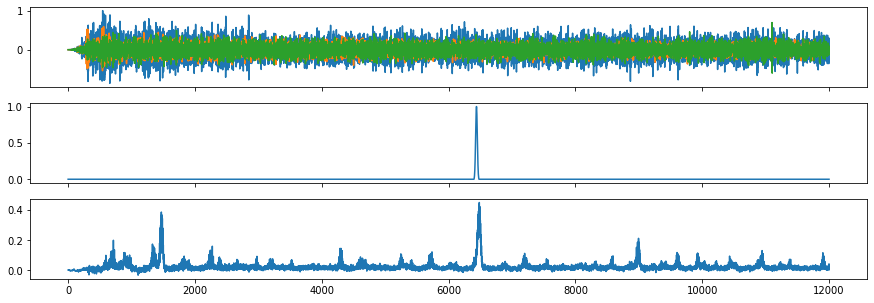

In [188]:
    pdict['w_len'] = 5*60
    gen_tst = gen(cat_tst, pdict)
    XX, YY = next(gen_tst)
    ZZ = model.predict(XX)
    
    idx = np.random.randint(pdict['bs'])
    fig, ax = plt.subplots(3, 1, figsize=(15,5), sharex=True)
    _ = ax[0].plot(XX[idx])
    _ = ax[1].plot(YY[idx])
    _ = ax[2].plot(ZZ[idx])
    plt.savefig(f'snr{snr}467.jpg')
#     plt.clf()

In [432]:
model, model_name = load_custom_model(pdict)
model.summary()

gen_trn = gen(cat_trn, pdict)
gen_val = gen(cat_val, pdict)

t_step = 100
v_step = 10

my_hist = model.fit_generator(gen_trn, steps_per_epoch=t_step, epochs=5000,
                                  validation_data=gen_val, validation_steps=v_step,
                                  use_multiprocessing=True,
                                  callbacks=get_callbacks(model_name, model_folder, log_folder),
                                  workers = 8,
                                  max_queue_size=10)

building new model:
 models/f:45|k:15|d:1x2x4x8x16|s:1|bs:20|w_len:300|c_len:2|w_snr:10|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:0.0001|pat:10|time:20-06-11-16-55-55.h5
Receptive Field Length: 10.85 seconds
Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_408 (Conv1D)             (None, None, 45)     2070        input_27[0][0]                   
__________________________________________________________________________________________________
activation_272 (Activation)     (None, None, 45)     0           conv1d_408[0][0]                 
__________________________________________________

Epoch 1/5000
100/100 [==============================] - 23s 234ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 2/5000
100/100 [==============================] - 23s 234ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/5000
100/100 [==============================] - 23s 232ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/5000
 52/100 [==============>...............] - ETA: 8s - loss: 0.0020

Process Keras_worker_ForkPoolWorker-943:
Process Keras_worker_ForkPoolWorker-942:
Process Keras_worker_ForkPoolWorker-944:
Process Keras_worker_ForkPoolWorker-941:
Process Keras_worker_ForkPoolWorker-940:
Process Keras_worker_ForkPoolWorker-945:
Process Keras_worker_ForkPoolWorker-939:
Process Keras_worker_ForkPoolWorker-946:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/

KeyboardInterrupt: 

  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/dickey/anaconda3/envs/SeisTF2_1/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/dickey/anacon

In [436]:
my_time = pdict['time']
pdict = {}
pdict['iniW'] = my_time
model, model_name = load_custom_model(pdict)
pdict = name2param(model_name)
    
pdict['w_len'] = 5*60
big_model, _ = load_custom_model(pdict)
big_model.set_weights(model.get_weights())

gen_tst = gen(cat_tst, pdict)
XX, YY = next(gen_tst)
ZZ = big_model.predict(XX)

loading previous model:
 models/f:45|k:15|d:1x2x4x8x16|s:1|bs:20|w_len:30|c_len:2|w_snr:10|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:0.0001|pat:10|time:20-06-11-17-00-54.h5
Receptive Field Length: 10.85 seconds
building new model:
 models/f:45|k:15|d:1x2x4x8x16|s:1|bs:20|w_len:300|c_len:2|w_snr:10|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:0.0001|pat:10|time:20-06-11-17-00-54.h5
Receptive Field Length: 10.85 seconds


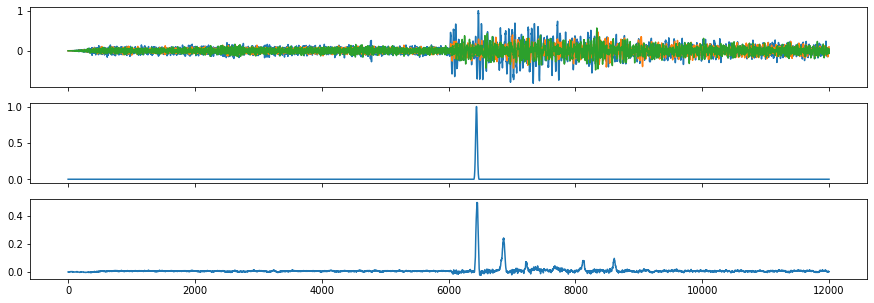

In [437]:
idx = np.random.randint(pdict['bs'])
fig, ax = plt.subplots(3, 1, figsize=(15,5), sharex=True)
_ = ax[0].plot(XX[idx])
_ = ax[1].plot(YY[idx])
_ = ax[2].plot(ZZ[idx])

In [30]:
pdict = {}
pdict['iniW'] = '19-11-25-20-00-45'
model, model_name = load_custom_model(pdict, '../DeepSyn/models')
pdict = name2param(model_name)

pdict['p_bnd'] = [1,10]

print('generating...')
gen_tst = gen(cat_tst, pdict)
XX, YY = next(gen_tst)

print('predicting...')
ZZ = model.predict(XX)

loading previous model:
 ../DeepSyn/models/f:16|k:15|d:1x2x4x8|s:1|bs:16|w_len:300|w_buf:10|c_len:0.8|c_buf:9|c_shp:line|c_amp:1|r_smp:20|cmpts:ZNE|n:True|n_amp:1e-06|lr:0.001|pat:5|time:19-11-25-20-00-45.h5
Receptive Field Length: 10.5 seconds
generating...
predicting...


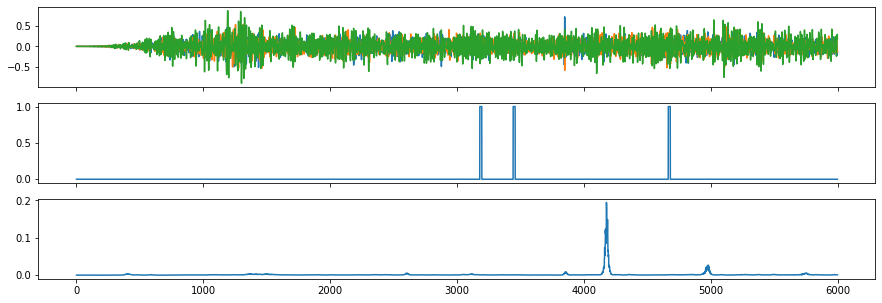

In [44]:
idx = np.random.randint(pdict['bs'])
fig, ax = plt.subplots(3, 1, figsize=(15,5), sharex=True)
_ = ax[0].plot(XX[idx])
_ = ax[1].plot(YY[idx])
_ = ax[2].plot(ZZ[idx])

In [67]:
phase_type_dict = {}
phase_type_dict['regional_P'] = ['Pn', 'Pg']
phase_type_dict['teleseis_P'] = ['P', 'PKP', 'pP', 'I', 'sP', 'PKKPbc', 'PKP2', 'PP', 'PcP', 'SKPbc', 'PKiKP', 'pPKP', 'PKPbc', 'SKP', 'ScP', 'SKKPbc']
phase_type_dict['secondary']  = ['Sn', 'S', 'ScS', 'Rg', 'I', 'LR']
phase_type_dict['surface']    = ['Lg']

In [105]:
y_true = np.array([[1., 0., 0.], [0., 1., 0.]])
y_pred = np.array([[.9, .05, .05], [.05, .89, .06]])

In [149]:
y_pred = np.random.rand(2,5,3)
y_true = np.round(tf.nn.softmax(y_pred**-3,axis=-1), 0)
y_pred = tf.nn.softmax(y_pred**-1.1,axis=-1) 
print(np.round(y_pred,3))
print(y_true)

[[[0.    1.    0.   ]
  [0.16  0.246 0.594]
  [0.194 0.113 0.693]
  [0.435 0.217 0.348]
  [0.051 0.677 0.272]]

 [[0.645 0.202 0.153]
  [0.    0.    1.   ]
  [1.    0.    0.   ]
  [0.    0.    1.   ]
  [0.002 0.001 0.996]]]
[[[0. 1. 0.]
  [0. 0. 1.]
  [0. 0. 1.]
  [1. 0. 0.]
  [0. 1. 0.]]

 [[1. 0. 0.]
  [0. 0. 1.]
  [1. 0. 0.]
  [0. 0. 1.]
  [0. 0. 1.]]]


In [150]:
print(y_true.shape)
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  y_true,
  y_pred)
loss

(2, 5, 3)


<tf.Tensor: id=1536585, shape=(), dtype=float64, numpy=0.2554333806037903>

In [148]:
print(y_true.shape)
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  y_true,
  y_pred)
loss

(2, 5, 3)


<tf.Tensor: id=1536547, shape=(), dtype=float64, numpy=0.12368110567331314>

In [27]:
d = [1, 2, 4, 8]
k = 15
RecFldLen(k,d)/40

5.25

In [25]:
def RecFldLen(k,d):
    r = 0
    for d_ in d:
        r = r + d_ * (k-1)
    return r